In [1]:
import os, json
from utils import session_config
from data_loader import load_data, Episode_generator
from models import load_model
from trainers.train_utils import calc_prototypes, calc_euclidian_dists, calc_probability_with_dists, loss_func, cal_metric

from functools import partial
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
session_config.setup_gpus(True, 0.9)

1 Physical GPUs, 1 Logical GPUs


# 1. load configuration file

In [3]:
config_filename = "configs/mini_imagenet_bof_fsl.json"

In [4]:
with open(config_filename, "r") as file:
    config = json.load(file)

In [5]:
print(config)

{'dataset_name': 'mini_imagenet', 'data_dir': '/home/files/datasets/mini_imagenet', 'input_shape': [84, 84, 3], 'model_name': 'bag_of_prototypes', 'checkpoint_dir': 'checkpoints/bof', 'train': {'gpu_id': '1', 'n_epoch': 300, 'n_episode': 100, 'n_way': 30, 'n_support': 5, 'n_query': 15, 'learning_rate': 0.001, 'patience': 50, 'pretrained_type': 'base', 'checkpoint_name': 'None'}, 'test': {'gpu_id': '0', 'n_episode': 100, 'n_way': 5, 'n_support': 5, 'n_query': 15, 'pretrained_type': 'latest', 'checkpoint_name': 'None'}}


In [6]:
print(config["train"])

{'gpu_id': '1', 'n_epoch': 300, 'n_episode': 100, 'n_way': 30, 'n_support': 5, 'n_query': 15, 'learning_rate': 0.001, 'patience': 50, 'pretrained_type': 'base', 'checkpoint_name': 'None'}


In [7]:
print(config["test"])

{'gpu_id': '0', 'n_episode': 100, 'n_way': 5, 'n_support': 5, 'n_query': 15, 'pretrained_type': 'latest', 'checkpoint_name': 'None'}


# 2. load data pipeline

In [8]:
#ds = load_data(["train", "val", "test"], config)
ds = load_data(["train", "val", "test"], config)

In [9]:
ds["val"].shape #shape of data

(16, 600, 84, 84, 3)

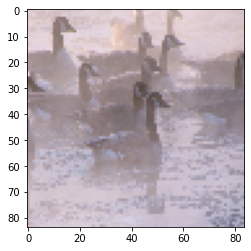

In [10]:
plt.imshow(ds["val"][0,0])

In [11]:
print(ds["val"][0,0,:10,:10])

[[[0.8745098  0.8        0.78431373]
  [0.85882353 0.78431373 0.76862745]
  [0.85098039 0.77647059 0.76078431]
  [0.85490196 0.77647059 0.78431373]
  [0.87843137 0.8        0.80392157]
  [0.83921569 0.76470588 0.74901961]
  [0.83921569 0.76862745 0.76470588]
  [0.8745098  0.81176471 0.81960784]
  [0.87058824 0.79607843 0.80392157]
  [0.85490196 0.78039216 0.80392157]]

 [[0.89803922 0.83529412 0.83921569]
  [0.8745098  0.80784314 0.81176471]
  [0.87058824 0.80784314 0.81176471]
  [0.85882353 0.78039216 0.78823529]
  [0.83529412 0.75686275 0.76078431]
  [0.82745098 0.75294118 0.75686275]
  [0.82745098 0.75294118 0.76078431]
  [0.85490196 0.78823529 0.81176471]
  [0.84313725 0.76862745 0.79215686]
  [0.83137255 0.75686275 0.77254902]]

 [[0.85098039 0.77647059 0.78431373]
  [0.85882353 0.78431373 0.79215686]
  [0.90980392 0.83529412 0.84313725]
  [0.88235294 0.80392157 0.80784314]
  [0.83529412 0.75686275 0.76470588]
  [0.82352941 0.76078431 0.76470588]
  [0.83921569 0.76862745 0.7764705

In [12]:
n_way = config["train"]["n_way"]
n_support = config["train"]["n_support"]
n_query = config["train"]["n_query"]
Epi_gen = Episode_generator(ds["train"], n_way, n_support, n_query)
train_ds = Epi_gen.pipeline()


val_n_way = config["test"]["n_way"]
val_n_support = config["test"]["n_support"]
val_n_query = config["test"]["n_query"]
Epi_gen = Episode_generator(ds["val"], val_n_way, val_n_support, val_n_query)
val_ds = Epi_gen.pipeline()

Epi_gen = Episode_generator(ds["test"], val_n_way, val_n_support, val_n_query)
test_ds = Epi_gen.pipeline()

In [13]:
for i, (support,query) in enumerate(train_ds.take(1)):
    print("{}-th episode".format(i+1))
    print("support set", support.shape)
    print("query set", query.shape)

1-th episode
support set (30, 5, 84, 84, 3)
query set (30, 15, 84, 84, 3)


In [14]:
for i, (support,query) in enumerate(val_ds.take(1)):
    print("{}-th episode".format(i+1))
    print("support set", support.shape)
    print("query set", query.shape)

1-th episode
support set (5, 5, 84, 84, 3)
query set (5, 15, 84, 84, 3)


In [15]:
for i, (support,query) in enumerate(test_ds.take(1)):
    print("{}-th episode".format(i+1))
    print("support set", support.shape)
    print("query set", query.shape)

1-th episode
support set (5, 5, 84, 84, 3)
query set (5, 15, 84, 84, 3)


# 1. load Prototypical network 

In [16]:
model = load_model(config)

In [17]:
H,W,C = config["input_shape"]
model(np.ones([1,H,W,C], np.float32))

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[7.8129355e-04, 0.0000000e+00, 2.6642813e-03, 2.1037317e-03,
        0.0000000e+00, 0.0000000e+00, 4.8506455e-04, 2.6632647e-04,
        0.0000000e+00, 2.0284327e-03, 1.2495414e-03, 8.3287057e-05,
        8.0933404e-04, 0.0000000e+00, 4.8897811e-04, 1.2212356e-03,
        3.3314835e-05, 2.3137403e-03, 1.1303412e-03, 0.0000000e+00,
        9.2995312e-04, 0.0000000e+00, 1.1337230e-03, 0.0000000e+00,
        1.5515272e-03, 2.4109257e-03, 1.3794911e-03, 2.9045726e-05,
        1.6698553e-03, 1.1180134e-03, 2.5607222e-03, 0.0000000e+00,
        1.2547638e-03, 3.5919179e-04, 0.0000000e+00, 9.9240441e-04,
        1.9837189e-03, 1.3648959e-04, 2.0581966e-03, 1.6951422e-05,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 8.5548370e-04,
        6.5793603e-04, 2.6632581e-05, 5.3171811e-06, 0.0000000e+00,
        0.0000000e+00, 2.9759397e-04, 2.0454634e-06, 1.1358426e-03,
        0.0000000e+00, 1.7230589e-03, 0.0000000e+00, 6.8734156e-04,

In [18]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 84, 84, 64)           256       
_________________________________________________________________
batch_normalization (BatchNo (1, 84, 84, 64)           256       
_________________________________________________________________
re_lu (ReLU)                 (1, 84, 84, 64)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 84, 84, 64)           36928     
_________________________________________________________________
batch_normalization_1 (Batch (1, 84, 84, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (1, 84, 84, 64)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 84, 84, 64)           4

# Training

In [19]:
log_dir = os.path.join('logs', "proto_bof")
if os.path.isdir(log_dir):
        raise ValueError("log directory exists. checkout your experiment name in configure file.")
summary_writer = tf.summary.create_file_writer(log_dir)

In [20]:
@tf.function
def train_step(query, support, model, optimizer, n_way, n_query, n_support):
    with tf.GradientTape() as tape:
        query_embeddings = model(query)
        support_embeddings = model(support)

        prototypes = calc_prototypes(support_embeddings, n_way, n_support)
        dists = calc_euclidian_dists(query_embeddings, prototypes)
        log_p_y = calc_probability_with_dists(dists, n_way, n_query)
        loss, pred = loss_func(log_p_y, n_way, n_query)
        eq, acc = cal_metric(log_p_y, n_way, n_query)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, eq, acc

@tf.function
def val_step(query, support, model, n_way, n_query, n_support):
    query_embeddings = model(query)
    support_embeddings = model(support)
    
    prototypes = calc_prototypes(support_embeddings, n_way, n_support)
    dists = calc_euclidian_dists(query_embeddings, prototypes)
    log_p_y = calc_probability_with_dists(dists, n_way, n_query)
    loss, pred = loss_func(log_p_y, n_way, n_query)
    eq, acc = cal_metric(log_p_y, n_way, n_query)
    return loss, eq, acc

In [21]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=config["train"]["learning_rate"])

n_epoch = config["train"]["n_epoch"]
n_episode = config["train"]["n_episode"]
val_n_episode = config["test"]["n_episode"]

trainer = partial(train_step, model=model, optimizer=adam_optimizer, n_way=n_way, n_query=n_query, n_support=n_support)
validator = partial(val_step, model=model, n_way=val_n_way, n_query=val_n_query, n_support=val_n_support)

In [22]:
for epoch in range(n_epoch):
    train_loss = tf.metrics.Mean(name='train_loss')
    val_loss = tf.metrics.Mean(name='val_loss')
    train_acc = tf.metrics.Mean(name='train_accuracy')
    val_acc = tf.metrics.Mean(name='val_accuracy')
    
    print("{} epoch start".format(epoch+1))
    #Training
    for episode, (support, query) in enumerate(train_ds):
        query = tf.reshape(query, [-1,H,W,C])
        support = tf.reshape(support, [-1,H,W,C])
        loss, eq, acc = trainer(query, support)
        train_loss(loss)
        train_acc(acc)
        if ((episode+1)%20) == 0:
            print("Episode {}".format(episode+1))
        if episode+1 == n_episode:
            break
    #validation 
    for episode, (support, query) in enumerate(val_ds):
        query = tf.reshape(query, [-1,H,W,C])
        support = tf.reshape(support, [-1,H,W,C])
        loss, eq, acc = validator(query, support)
        val_loss(loss)
        val_acc(acc)
        if episode+1 == val_n_episode:
            break
    print("{} epoch end. Loss : {}, Accuracy : {}, Val-loss : {}, Val-Accuracy : {}".format(epoch+1, 
                                                                                             train_loss.result(),
                                                                                             train_acc.result(),
                                                                                             val_loss.result(),
                                                                                             val_acc.result() ))
    with summary_writer.as_default():
                tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
                tf.summary.scalar('train_acc', train_acc.result(), step=epoch)
                tf.summary.scalar('val_loss', val_loss.result(), step=epoch)
                tf.summary.scalar('val_acc', val_acc.result(), step=epoch)            

1 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
1 epoch end. Loss : 3.3455963134765625, Accuracy : 0.06975555419921875, Val-loss : 1.5652878284454346, Val-Accuracy : 0.3033333718776703
2 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
2 epoch end. Loss : 3.278952121734619, Accuracy : 0.07617779076099396, Val-loss : 1.522822380065918, Val-Accuracy : 0.31240004301071167
3 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
3 epoch end. Loss : 3.2659759521484375, Accuracy : 0.08162223547697067, Val-loss : 1.495733618736267, Val-Accuracy : 0.32760003209114075
4 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
4 epoch end. Loss : 3.2384448051452637, Accuracy : 0.08651112765073776, Val-loss : 1.5187629461288452, Val-Accuracy : 0.3249334394931793
5 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
5 epoch end. Loss : 3.2445590496063232, Accuracy : 0.08773333579301834, Val-loss : 1.4891691207885742, 

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
41 epoch end. Loss : 2.6464200019836426, Accuracy : 0.2397555112838745, Val-loss : 1.265721321105957, Val-Accuracy : 0.4689333438873291
42 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
42 epoch end. Loss : 2.616544485092163, Accuracy : 0.24508890509605408, Val-loss : 1.2713322639465332, Val-Accuracy : 0.47306668758392334
43 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
43 epoch end. Loss : 2.631958246231079, Accuracy : 0.24513334035873413, Val-loss : 1.271672010421753, Val-Accuracy : 0.46826666593551636
44 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
44 epoch end. Loss : 2.6329538822174072, Accuracy : 0.24188892543315887, Val-loss : 1.2159185409545898, Val-Accuracy : 0.5056000351905823
45 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
45 epoch end. Loss : 2.6053271293640137, Accuracy : 0.2519778311252594, Val-loss : 1.2506508827209473, Val-Accu

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
81 epoch end. Loss : 2.344107151031494, Accuracy : 0.3132000267505646, Val-loss : 1.2587034702301025, Val-Accuracy : 0.49720004200935364
82 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
82 epoch end. Loss : 2.3449432849884033, Accuracy : 0.3106444776058197, Val-loss : 1.2386693954467773, Val-Accuracy : 0.5020000338554382
83 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
83 epoch end. Loss : 2.324695110321045, Accuracy : 0.31671106815338135, Val-loss : 1.257735013961792, Val-Accuracy : 0.49346664547920227
84 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
84 epoch end. Loss : 2.3228089809417725, Accuracy : 0.31642216444015503, Val-loss : 1.2529535293579102, Val-Accuracy : 0.4904000163078308
85 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
85 epoch end. Loss : 2.3055551052093506, Accuracy : 0.32082220911979675, Val-loss : 1.2705029249191284, Val-Acc

Episode 100
120 epoch end. Loss : 2.1073379516601562, Accuracy : 0.36706677079200745, Val-loss : 1.278398871421814, Val-Accuracy : 0.4901331961154938
121 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
121 epoch end. Loss : 2.1071507930755615, Accuracy : 0.36059996485710144, Val-loss : 1.2746182680130005, Val-Accuracy : 0.4830666482448578
122 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
122 epoch end. Loss : 2.0863730907440186, Accuracy : 0.36591118574142456, Val-loss : 1.308921217918396, Val-Accuracy : 0.4909334182739258
123 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
123 epoch end. Loss : 2.0860774517059326, Accuracy : 0.36477792263031006, Val-loss : 1.2758358716964722, Val-Accuracy : 0.48440006375312805
124 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
124 epoch end. Loss : 2.088543653488159, Accuracy : 0.3706444501876831, Val-loss : 1.272469162940979, Val-Accuracy : 0.4880000054836273
125 epoch

Episode 80
Episode 100
159 epoch end. Loss : 1.9126837253570557, Accuracy : 0.4097111225128174, Val-loss : 1.3647831678390503, Val-Accuracy : 0.4771999418735504
160 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
160 epoch end. Loss : 1.9406315088272095, Accuracy : 0.39697781205177307, Val-loss : 1.3702788352966309, Val-Accuracy : 0.4635998606681824
161 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
161 epoch end. Loss : 1.9408131837844849, Accuracy : 0.39951109886169434, Val-loss : 1.3677761554718018, Val-Accuracy : 0.4801332354545593
162 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
162 epoch end. Loss : 1.9084895849227905, Accuracy : 0.4052666425704956, Val-loss : 1.319637656211853, Val-Accuracy : 0.4790666997432709
163 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
163 epoch end. Loss : 1.913454294204712, Accuracy : 0.40880000591278076, Val-loss : 1.3708003759384155, Val-Accuracy : 0.474533349275589

Episode 60
Episode 80
Episode 100
198 epoch end. Loss : 1.7552303075790405, Accuracy : 0.44913333654403687, Val-loss : 1.3692930936813354, Val-Accuracy : 0.47546663880348206
199 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
199 epoch end. Loss : 1.7777683734893799, Accuracy : 0.4344666302204132, Val-loss : 1.412707805633545, Val-Accuracy : 0.4811999797821045
200 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
200 epoch end. Loss : 1.773054599761963, Accuracy : 0.4383554756641388, Val-loss : 1.44614839553833, Val-Accuracy : 0.4567999243736267
201 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
201 epoch end. Loss : 1.7628583908081055, Accuracy : 0.44231116771698, Val-loss : 1.443952202796936, Val-Accuracy : 0.4550666809082031
202 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
202 epoch end. Loss : 1.7373944520950317, Accuracy : 0.4471554458141327, Val-loss : 1.4473528861999512, Val-Accuracy : 0.4531999230

Episode 100
237 epoch end. Loss : 1.6506547927856445, Accuracy : 0.47011104226112366, Val-loss : 1.5220893621444702, Val-Accuracy : 0.4449332058429718
238 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
238 epoch end. Loss : 1.6292271614074707, Accuracy : 0.4751777946949005, Val-loss : 1.5128134489059448, Val-Accuracy : 0.45319998264312744
239 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
239 epoch end. Loss : 1.6457164287567139, Accuracy : 0.4691111445426941, Val-loss : 1.5329489707946777, Val-Accuracy : 0.4329332411289215
240 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
240 epoch end. Loss : 1.646608829498291, Accuracy : 0.4683777689933777, Val-loss : 1.470885157585144, Val-Accuracy : 0.46293342113494873
241 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
241 epoch end. Loss : 1.6265511512756348, Accuracy : 0.47388893365859985, Val-loss : 1.4223244190216064, Val-Accuracy : 0.47039997577667236
242 epo

Episode 100
276 epoch end. Loss : 1.5318312644958496, Accuracy : 0.49826663732528687, Val-loss : 1.6113919019699097, Val-Accuracy : 0.4386667013168335
277 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
277 epoch end. Loss : 1.528039813041687, Accuracy : 0.4997777044773102, Val-loss : 1.6098833084106445, Val-Accuracy : 0.44386669993400574
278 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
278 epoch end. Loss : 1.5468988418579102, Accuracy : 0.49486660957336426, Val-loss : 1.5815093517303467, Val-Accuracy : 0.4510667026042938
279 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
279 epoch end. Loss : 1.5043765306472778, Accuracy : 0.5085111856460571, Val-loss : 1.595937967300415, Val-Accuracy : 0.4505334198474884
280 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
280 epoch end. Loss : 1.5299214124679565, Accuracy : 0.5007110238075256, Val-loss : 1.6599525213241577, Val-Accuracy : 0.44293347001075745
281 epoc

In [23]:
model.save('bof.h5')

# Accuracy test

In [24]:
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')
for epoch in range(n_epoch):
    print("{} epoch start".format(epoch+1)) 
    for episode, (support, query) in enumerate(val_ds):
        query = tf.reshape(query, [-1,H,W,C])
        support = tf.reshape(support, [-1,H,W,C])
        loss, eq, acc = validator(query, support)
        val_loss(loss)
        val_acc(acc)
        if episode+1 == val_n_episode:
            break
    print("{} epoch end. Loss : {}, Accuracy : {}, Val-loss : {}, Val-Accuracy : {}".format(epoch+1, 
                                                                                             val_loss.result(),
                                                                                             val_acc.result() ))

1 epoch start
1 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6084789037704468, Val-Accuracy : 0.45060020685195923
2 epoch start
2 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6238248348236084, Val-Accuracy : 0.4456445872783661
3 epoch start
3 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6254277229309082, Val-Accuracy : 0.44540005922317505
4 epoch start
4 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6247766017913818, Val-Accuracy : 0.4436800479888916
5 epoch start
5 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.627834439277649, Val-Accuracy : 0.441933274269104
6 epoch start
6 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.629744291305542, Val-Accuracy : 0.44310468435287476
7 epoch start
7 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.63

55 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6144442558288574, Val-Accuracy : 0.44840458035469055
56 epoch start
56 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6144683361053467, Val-Accuracy : 0.4481845498085022
57 epoch start
57 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.614232063293457, Val-Accuracy : 0.44818809628486633
58 epoch start
58 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.613601565361023, Val-Accuracy : 0.44829121232032776
59 epoch start
59 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6143722534179688, Val-Accuracy : 0.44816187024116516
60 epoch start
60 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6146492958068848, Val-Accuracy : 0.4482007324695587
61 epoch start
61 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6

109 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6187644004821777, Val-Accuracy : 0.4468792676925659
110 epoch start
110 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6187313795089722, Val-Accuracy : 0.4468473792076111
111 epoch start
111 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6187138557434082, Val-Accuracy : 0.446893572807312
112 epoch start
112 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6189731359481812, Val-Accuracy : 0.44683727622032166
113 epoch start
113 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6184180974960327, Val-Accuracy : 0.44695407152175903
114 epoch start
114 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6185723543167114, Val-Accuracy : 0.44710129499435425
115 epoch start
115 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, V

163 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6188312768936157, Val-Accuracy : 0.44705599546432495
164 epoch start
164 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6191611289978027, Val-Accuracy : 0.4470036029815674
165 epoch start
165 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6190730333328247, Val-Accuracy : 0.4470023512840271
166 epoch start
166 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6189818382263184, Val-Accuracy : 0.44702041149139404
167 epoch start
167 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6192210912704468, Val-Accuracy : 0.4469738304615021
168 epoch start
168 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.619140386581421, Val-Accuracy : 0.44699880480766296
169 epoch start
169 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, V

217 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6186052560806274, Val-Accuracy : 0.44722554087638855
218 epoch start
218 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.618661880493164, Val-Accuracy : 0.44722411036491394
219 epoch start
219 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6188380718231201, Val-Accuracy : 0.44719398021698
220 epoch start
220 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6188040971755981, Val-Accuracy : 0.44721171259880066
221 epoch start
221 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6188496351242065, Val-Accuracy : 0.4472215175628662
222 epoch start
222 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Val-loss : 1.6189810037612915, Val-Accuracy : 0.44719594717025757
223 epoch start
223 epoch end. Loss : 1.4782277345657349, Accuracy : 0.5127111673355103, Va

KeyboardInterrupt: 